In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
import networkx as nx
from IPython.display import clear_output

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
colors = plt.cm.magma(np.linspace(.3,1,8))

In [4]:
def get_coloring(S):
    "get coloring correspoding to sparsity pattern"
    
    n,d = S.shape
    G = nx.from_numpy_array(S.T@S)
    nx_color = nx.greedy_color(G)
    colors = np.array([nx_color[i] for i in range(d)])

    return colors

In [5]:
def coloring_recovery(A,S,coloring,m):
    """
    sparse recovery algorithm using coloring
    """

    n,d = A.shape
    
    c = max(coloring)+1
    
    mask = np.zeros((n,c))
    for i in range(c):
        mask[coloring==i,i] = 1
    
    G = np.tile(mask,int(np.ceil(m/c)))[:,:m] * np.random.choice([-1,1],size=(n,m))
    
    Z = A@G
    
    A_ = np.zeros((n,d))
    for i in range(c):
        A_[:,coloring==i] += S[:,coloring==i]*np.mean((S@G[:,i::c])*Z[:,i::c],axis=1)[:,None]
    
    return A_

In [6]:
def sparse_recovery(A,S,m):
    """
    sparse recovery algorithm from [ACHKMM24]
    """
    
    n,d = A.shape
    G = np.random.randn(d,m)
    Z = A@G

    A_ = np.zeros((n,d))

    for i in range(n):
        si = np.where(S[i])[0]
        A_[i,si] = np.linalg.lstsq(G[si].T,Z[i],rcond=None)[0]

    return A_

# Model Problem

In [7]:
n = 1000
B = np.diag(4*np.ones(n)) + np.diag(-np.ones(n-1),1) + np.diag(-np.ones(n-1),-1)
A = np.linalg.inv(B)
A /= np.linalg.norm(A)

In [8]:
bs = [0,1,2,3,4]
ms = np.geomspace(1,5e2+1,20,dtype=int)
n_trials = 100


err_all = {}
err_color_all = {}
err_opt_all = {}
for b in bs:

    err = np.full((len(ms),n_trials),np.nan)
    err_color = np.full((len(ms),n_trials),np.nan)

    s = 2*b+1
    S = np.eye(n,dtype=bool)
    for i in range(1,b+1):
        S += np.diag(np.ones(n-i,dtype=bool),i) + np.diag(np.ones(n-i,dtype=bool),-i)

    coloring = np.arange(n)%s
    for i,m in enumerate(ms):
        print(f"{b},{m}")
        clear_output(wait=True)
        
        if m<s+2:
            continue
        for j in range(n_trials):
            A_ = sparse_recovery(A,S,m)
            err[i,j] = np.linalg.norm(A_ - A*S)

            A_ = coloring_recovery(A,S,coloring,m)
            err_color[i,j] = np.linalg.norm(A_ - A*S)

    err_all[b] = err
    err_color_all[b] = err_color
    err_opt_all[b] = np.linalg.norm(A-A*S)

4,501


In [9]:
np.save('model.npy',[err_all,err_color_all,err_opt_all],allow_pickle=True)
[err_all,err_color_all,err_opt_all] = np.load('model.npy',allow_pickle=True)

/tmp/ipykernel_642078/404389838.py:17: RuntimeWarning: divide by zero encountered in divide
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/404389838.py:17: RuntimeWarning: invalid value encountered in sqrt
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/404389838.py:26: RuntimeWarning: divide by zero encountered in divide
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/404389838.py:26: RuntimeWarning: invalid value encountered in sqrt
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)


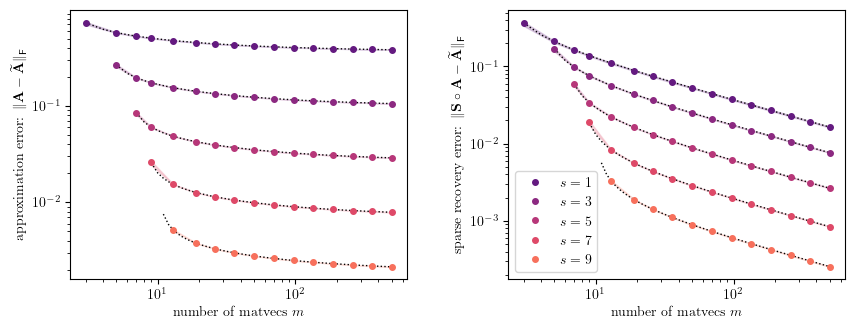

In [10]:
fig,axs = plt.subplots(1,2,figsize=(10,3.5))
plt.subplots_adjust(wspace=.3)

for i,b in enumerate(bs):
    c = colors[i]
    
    s = 2*b+1
    err = err_all[b]
    err_opt = err_opt_all[b]

    mean = np.mean(err**2,axis=1)**.5

    σ = 0.25
    minq = np.quantile(err,σ,axis=1)
    maxq = np.quantile(err,1-σ,axis=1)

    axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[0].plot(ms,err_opt+mean,marker='o',ms=4,color=c,ls='None',label=f'$s={s}$')
    axs[0].fill_between(ms,err_opt+minq,err_opt+maxq,alpha=.2,color=c);

    axs[0].set_yscale('log')
    axs[0].set_xscale('log')


    axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[1].plot(ms,mean,marker='o',ms=4,color=c,ls='None',label=f'$s={s}$')
    axs[1].fill_between(ms,minq,maxq,alpha=.2,color=c);

    axs[1].set_yscale('log')
    axs[1].set_xscale('log')


axs[0].set_ylabel('approximation error: $\|\mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')
axs[1].set_ylabel('sparse recovery error: $\|\mathbf{S}\circ \mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')

axs[0].set_xlabel('number of matvecs $m$')
axs[1].set_xlabel('number of matvecs $m$')


plt.legend()

plt.savefig('imgs/inverse_decay.pdf')

/tmp/ipykernel_642078/1068354937.py:17: RuntimeWarning: divide by zero encountered in divide
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/1068354937.py:17: RuntimeWarning: invalid value encountered in sqrt
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/1068354937.py:26: RuntimeWarning: divide by zero encountered in divide
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/1068354937.py:26: RuntimeWarning: invalid value encountered in sqrt
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)


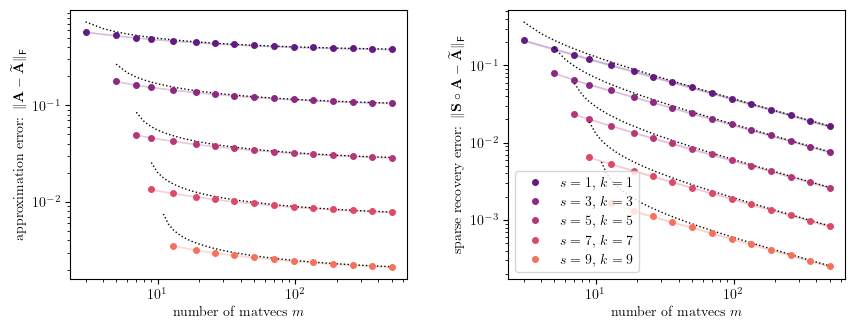

In [11]:
fig,axs = plt.subplots(1,2,figsize=(10,3.5))
plt.subplots_adjust(wspace=.3)

for i,b in enumerate(bs):
    c = colors[i]
    
    s = 2*b+1
    err = err_color_all[b]
    err_opt = err_opt_all[b]

    mean = np.mean(err**2,axis=1)**.5

    σ = 0.25
    minq = np.quantile(err,σ,axis=1)
    maxq = np.quantile(err,1-σ,axis=1)

    axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[0].plot(ms,err_opt+mean,marker='o',ms=4,color=c,ls='None',label=f'$s={s}$')
    axs[0].fill_between(ms,err_opt+minq,err_opt+maxq,alpha=.2,color=c);

    axs[0].set_yscale('log')
    axs[0].set_xscale('log')


    axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[1].plot(ms,mean,marker='o',ms=4,color=c,ls='None',label=f'$s={s}$, $k={s}$')
    axs[1].fill_between(ms,minq,maxq,alpha=.2,color=c);

    axs[1].set_yscale('log')
    axs[1].set_xscale('log')


axs[0].set_ylabel('approximation error: $\|\mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')
axs[1].set_ylabel('sparse recovery error: $\|\mathbf{S}\circ \mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')

axs[0].set_xlabel('number of matvecs $m$')
axs[1].set_xlabel('number of matvecs $m$')


plt.legend()

plt.savefig('imgs/inverse_decay_color.pdf')

# Trefethen primes

In [12]:
n = 1000

b = 1

S = np.eye(n,dtype=bool)
for j in range(1,int(np.log2(n))):

    for i in range(2**j-b,2**j+b+1):
        S += np.diag(np.ones(n-i,dtype=bool),i) + np.diag(np.ones(n-i,dtype=bool),-i)

s = np.max(np.sum(S,axis=0))

In [13]:
B = np.diag(list(sympy.primerange(2, sympy.prime(n) + 1)))
for j in range(1,int(np.log2(n))+1):
    i = 2**j
    B += np.diag(np.ones(n-i,dtype=bool),i) + np.diag(np.ones(n-i,dtype=bool),-i)


A = np.linalg.inv(B)

A /= np.linalg.norm(A)

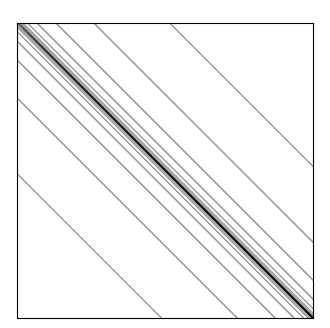

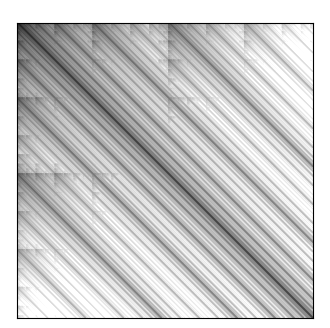

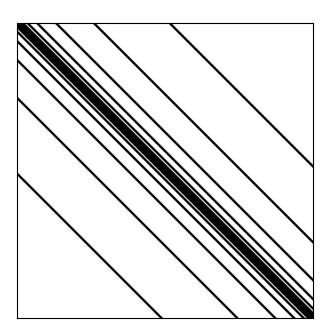

In [14]:
fig,axs = plt.subplots(2,1,figsize=(4,4),height_ratios=[1,36])
plt.subplots_adjust(hspace=.03)

axs[0].axis('off')

axs[1].imshow(np.abs(B),cmap='binary',norm=mpl.colors.LogNorm(vmin=1e-3,vmax=1e3))
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.savefig('imgs/tref_mat_orig.pdf')

b=5
S = np.zeros((n,n),dtype=bool)
for j in range(0,int(np.log2(n))+1):
    for i in range(max(0,2**j-b),min(2**j+b,n)+1):
        S += np.diag(np.ones(n-i,dtype=bool),i) + np.diag(np.ones(n-i,dtype=bool),-i)


fig,axs = plt.subplots(2,1,figsize=(4,4),height_ratios=[1,36])
plt.subplots_adjust(hspace=.03)

axs[0].axis('off')

axs[1].imshow(np.abs(A),cmap='binary',norm=mpl.colors.LogNorm())
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.savefig('imgs/tref_mat.pdf')

fig,axs = plt.subplots(2,1,figsize=(4,4),height_ratios=[1,36])
plt.subplots_adjust(hspace=.03)

axs[0].axis('off')

axs[1].imshow(S,cmap='binary')
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.savefig('imgs/tref_sparsity.pdf')

In [15]:
bs = [0,1,2,5]
ms = np.geomspace(21,7e2+1,20,dtype=int)
n_trials = 100

In [16]:
s_all = {}
err_all = {}
err_color_all = {}
cond_all = {}
err_opt_all = {}
colorings = {}
for b in bs:

    err = np.full((len(ms),n_trials),np.nan)
    err_color = np.full((len(ms),n_trials),np.nan)
    cond = np.full((len(ms),n_trials),np.nan)

    S = np.zeros((n,n),dtype=bool)
    for j in range(0,int(np.log2(n))+1):
        for i in range(max(0,2**j-b),min(2**j+b,n)+1):
            S += np.diag(np.ones(n-i,dtype=bool),i) + np.diag(np.ones(n-i,dtype=bool),-i)

    coloring = get_coloring(S)
    colorings[b] = coloring

    s = np.max(np.sum(S,axis=0))
    s_all[b] = s
    
    for i,m in enumerate(ms):

        print(f"{b},{m}")
        clear_output(wait=True)

        if m<s+2: 
            continue
        for j in range(n_trials):
            A_ = sparse_recovery(A,S,m)
            err[i,j] = np.linalg.norm(A_ - A*S)

            A_ = coloring_recovery(A,S,coloring,m)
            err_color[i,j] = np.linalg.norm(A_ - A*S)


    err_all[b] = err
    err_color_all[b] = err_color
    err_opt_all[b] = np.linalg.norm(A-A*S)

5,701


In [17]:
np.save('trefethen_primes.npy',[err_all,err_color_all,err_opt_all,s_all,colorings],allow_pickle=True)
[err_all,err_color_all,err_opt_all,s_all,colorings] = np.load('trefethen_primes.npy',allow_pickle=True)

/tmp/ipykernel_642078/2180474405.py:17: RuntimeWarning: divide by zero encountered in divide
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/2180474405.py:17: RuntimeWarning: invalid value encountered in sqrt
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/2180474405.py:26: RuntimeWarning: divide by zero encountered in divide
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/2180474405.py:26: RuntimeWarning: invalid value encountered in sqrt
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)


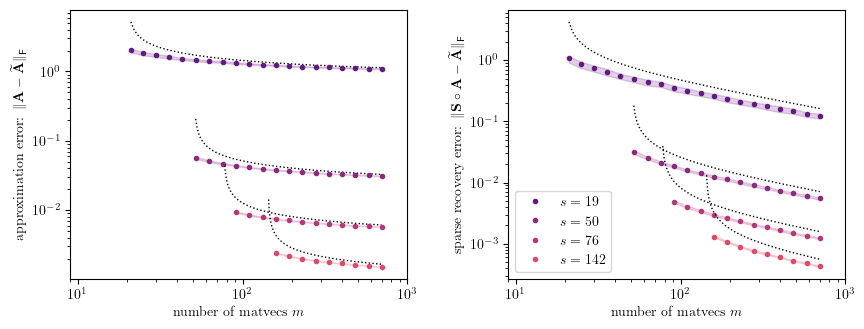

In [18]:
fig,axs = plt.subplots(1,2,figsize=(10,3.5))
plt.subplots_adjust(wspace=.3)

for i,b in enumerate(bs):
    c = colors[i]
    
    s = s_all[b]
    err = err_all[b]
    err_opt = err_opt_all[b]

    mean = np.mean(err**2,axis=1)**.5

    σ = 0.25
    minq = np.quantile(err,σ,axis=1)
    maxq = np.quantile(err,1-σ,axis=1)

    axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[0].plot(ms,err_opt+mean,marker='o',ms=3,color=c,ls='None',label=f'$s={s}$')
    axs[0].fill_between(ms,err_opt+minq,err_opt+maxq,alpha=.2,color=c);

    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_xlim([9,1000])

    axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[1].plot(ms,mean,marker='o',ms=3,color=c,ls='None',label=f'$s={s}$')
    axs[1].fill_between(ms,minq,maxq,alpha=.2,color=c);

    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_xlim([9,1000])

axs[0].set_ylabel('approximation error: $\|\mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')
axs[1].set_ylabel('sparse recovery error: $\|\mathbf{S}\circ \mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')

axs[0].set_xlabel('number of matvecs $m$')
axs[1].set_xlabel('number of matvecs $m$')


plt.legend()

plt.savefig('imgs/tref_inv.pdf')

/tmp/ipykernel_642078/3424137445.py:17: RuntimeWarning: divide by zero encountered in divide
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/3424137445.py:17: RuntimeWarning: invalid value encountered in sqrt
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/3424137445.py:26: RuntimeWarning: divide by zero encountered in divide
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/3424137445.py:26: RuntimeWarning: invalid value encountered in sqrt
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)


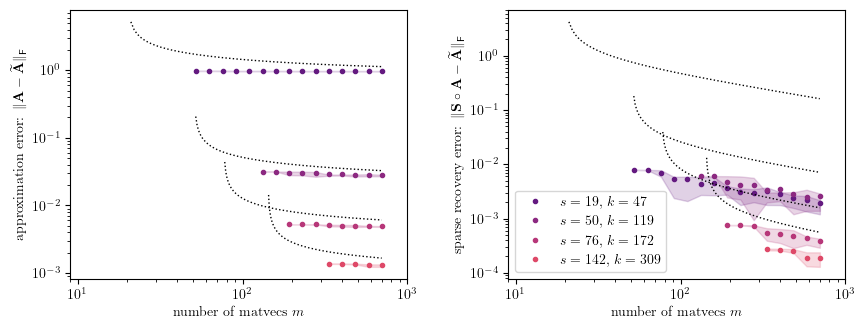

In [19]:
fig,axs = plt.subplots(1,2,figsize=(10,3.5))
plt.subplots_adjust(wspace=.3)

for i,b in enumerate(bs):
    c = colors[i]
    
    s = s_all[b]
    err = err_color_all[b]
    err_opt = err_opt_all[b]

    mean = np.mean(err**2,axis=1)**.5

    σ = 0.25
    minq = np.quantile(err,σ,axis=1)
    maxq = np.quantile(err,1-σ,axis=1)

    axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[0].plot(ms,err_opt+mean,marker='o',ms=3,color=c,ls='None',label=f'$s={s}$')
    axs[0].fill_between(ms,err_opt+minq,err_opt+maxq,alpha=.2,color=c);

    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_xlim([9,1000])

    axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[1].plot(ms,mean,marker='o',ms=3,color=c,ls='None',label=f'$s={s}$, $k={np.max(colorings[b])+1}$')
    axs[1].fill_between(ms,minq,maxq,alpha=.2,color=c);

    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_xlim([9,1000])

axs[0].set_ylabel('approximation error: $\|\mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')
axs[1].set_ylabel('sparse recovery error: $\|\mathbf{S}\circ \mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')

axs[0].set_xlabel('number of matvecs $m$')
axs[1].set_xlabel('number of matvecs $m$')


plt.legend()

plt.savefig('imgs/tref_inv_color.pdf')